Librerias

In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os


In [2]:
import pickle
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto a sys.path
module_path = Path('/Users/Cesar/Desktop/Proyecto-CSG/').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Añadir el directorio que contiene 'new_spectral_metric' a sys.path
new_spectral_metric_path = module_path / '/Users/Cesar/Desktop/Proyecto-CSG/new_spectral_metric/'
if new_spectral_metric_path not in sys.path:
    sys.path.append(str(new_spectral_metric_path))

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from new_spectral_metric.new_estimator import CumulativeGradientEstimator
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path


Lectura del dataset

In [3]:
# Lectura de dataset

directorio_dataset = ('../Datasets/Perros y Gatos')
directorio_dataset = pathlib.Path(directorio_dataset)

# Lectura de la carpeta train
directorio_train = ('../Datasets/Perros y Gatos/train')
directorio_train = pathlib.Path(directorio_train)

# Lectura de la carpeta test
directorio_test = ('../Datasets/Perros y Gatos/test')
directorio_test = pathlib.Path(directorio_test)


total_dataset = len(list(directorio_dataset.glob('*/*/*.jpg')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_train = len(list(directorio_train.glob('*/*.jpg')))  # Cuenta la cantidad de imagenes de train
total_test = len(list(directorio_test.glob('*/*.jpg')))  # Cuenta la cantidad de imagenes de test

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes train: {total_train}")
print(f"Total imagenes test: {total_test}")

Total imagenes dataset: 0
Total imagenes train: 0
Total imagenes test: 0


In [4]:
# Dimensiones de imagen y tamaño de batch
img_height = 32
img_width = 32
#batch_size = 32
batch_size = total_dataset

In [5]:

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 697 files belonging to 2 classes.


InvalidArgumentError: {{function_node __wrapped__BatchDatasetV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Batch size must be greater than zero. [Op:BatchDatasetV2] name: 

In [ ]:
# Contar el total de imágenes por clase en train y test
class_counts_train = {p.name: len(list(p.glob('*.jpg'))) for p in directorio_train.glob('*')}
class_counts_test = {p.name: len(list(p.glob('*.jpg'))) for p in directorio_test.glob('*')}




# Mostrar el total de imágenes por clase en train
print("\nTotal de imágenes por clase en train:")
for class_name, count in class_counts_train.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")
print(f"Total imagenes train: {total_train}")

# Mostrar el total de imágenes por clase en test
print("\nTotal de imágenes por clase en test:")
for class_name, count in class_counts_test.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")
print(f"Total imagenes test: {total_test}")


Total de imágenes por clase en train:
Clase: airplane, Número de imágenes: 5000
Clase: automobile, Número de imágenes: 5000
Clase: bird, Número de imágenes: 5000
Clase: cat, Número de imágenes: 5000
Clase: deer, Número de imágenes: 5000
Clase: dog, Número de imágenes: 5000
Clase: frog, Número de imágenes: 5000
Clase: horse, Número de imágenes: 5000
Clase: ship, Número de imágenes: 5000
Clase: truck, Número de imágenes: 5000
Total imagenes train: 50000

Total de imágenes por clase en test:
Clase: airplane, Número de imágenes: 1000
Clase: automobile, Número de imágenes: 1000
Clase: bird, Número de imágenes: 1000
Clase: cat, Número de imágenes: 1000
Clase: deer, Número de imágenes: 1000
Clase: dog, Número de imágenes: 1000
Clase: frog, Número de imágenes: 1000
Clase: horse, Número de imágenes: 1000
Clase: ship, Número de imágenes: 1000
Clase: truck, Número de imágenes: 1000
Total imagenes test: 10000


In [ ]:
# Nombres de las clases
class_names_train = list(class_counts_train.keys())
class_names_test = list(class_counts_test.keys())
class_names_total = sorted(list(set(class_names_train + class_names_test)))

# Mostrar el número de clases y los nombres
print(f"\nNúmero de clases en train: {len(class_names_train)}")
print(f"Nombres de las clases en train: {class_names_train}")

print(f"\nNúmero de clases en test: {len(class_names_test)}")
print(f"Nombres de las clases en test: {class_names_test}")

print(f"\nNúmero total de clases en el dataset: {len(class_names_total)}")   # Este valor cambio si el nombre de las clases es diferente
print(f"Nombres de todas las clases en el dataset: {class_names_total}")     # Este valor tambien cambia si el nombre de las clases es diferente


Número de clases en train: 10
Nombres de las clases en train: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Número de clases en test: 10
Nombres de las clases en test: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Número total de clases en el dataset: 10
Nombres de todas las clases en el dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Revisar etiquetas de las imágenes
for images, labels in all_images_in_dataset:
    labels = labels.numpy() if hasattr(labels, 'numpy') else labels
    for label in labels:
        assert label in [0, 1], f"Etiqueta inesperada {label} en la imagen."


In [ ]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(32, 32, 32, 3)


In [ ]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)

Calcular y visualizar la complejidad del dataset

c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\Cesar\AppData\Loc

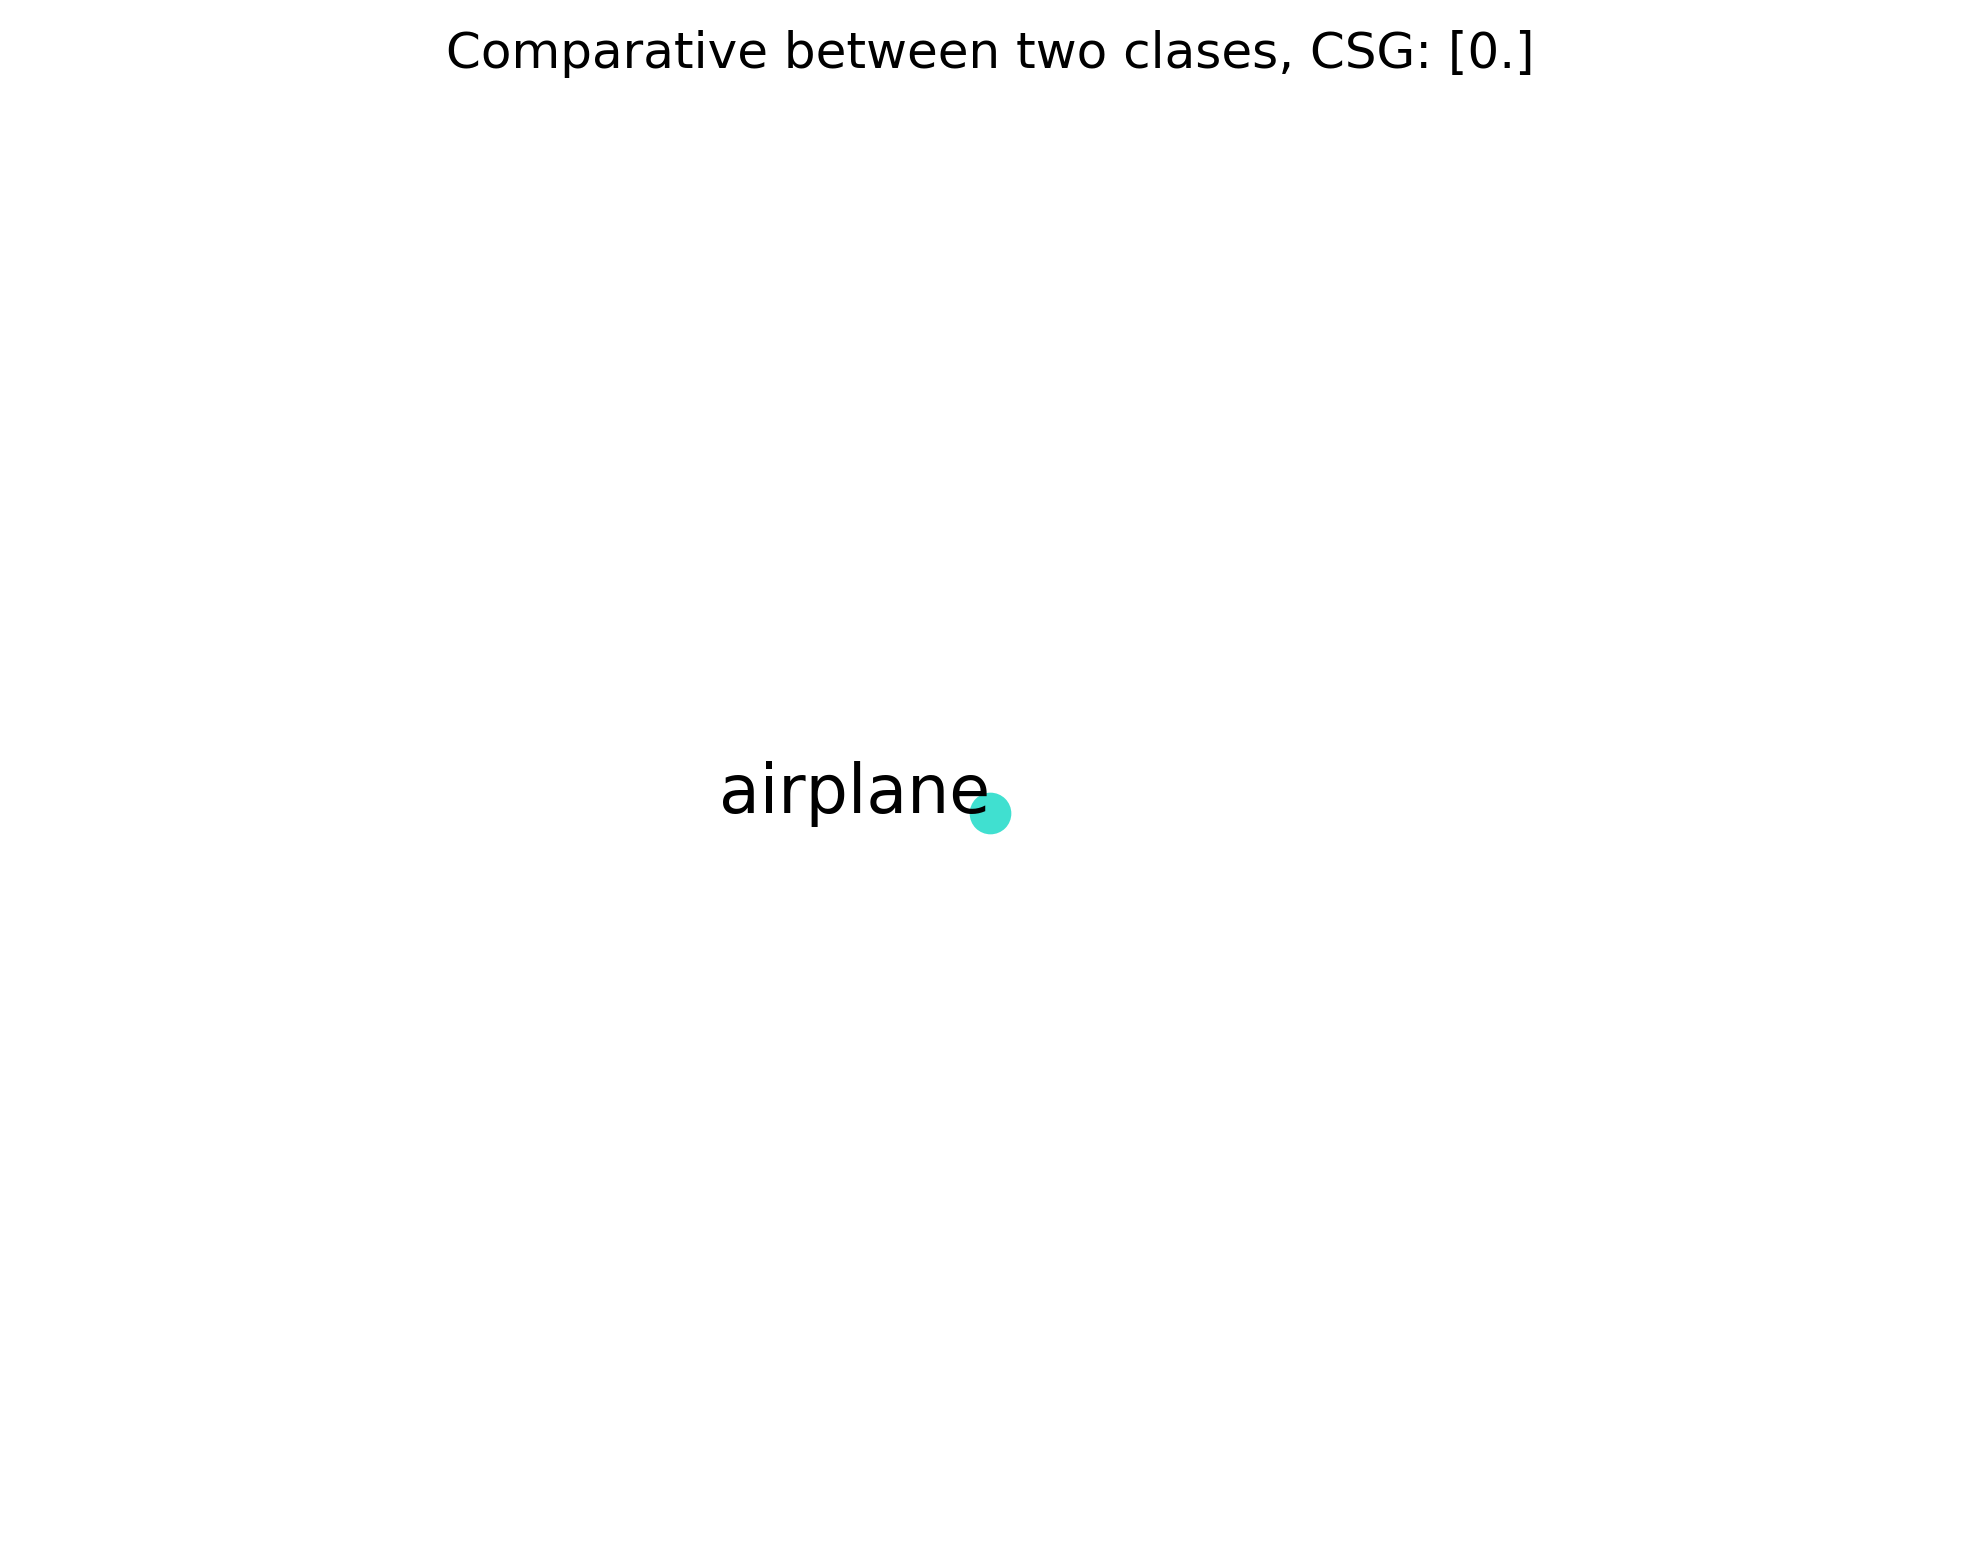

In [ ]:

# Inicializar el estimador
estimator = CumulativeGradientEstimator(M_sample=1000, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names_total)

Calcular la similitud entre clases

In [ ]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(clase_train, clase_test) for clase_train, clase_test in pairs if clase_train != clase_test]


# Asegúrate de que el índice de las clases no exceda la cantidad de clases en el dataset
filtered_pairs = [(clase_train, clase_test) for clase_train, clase_test in pairs 
                  if clase_train < len(class_names_total) and clase_test < len(class_names_total)]

# Obtener el par de clases menos similares
similitud_de_clases = filtered_pairs[0]
clase_train, clase_test = similitud_de_clases

print("Cálculo de similitud entre clases")
lst = []
for idx, (clase_train, clase_test) in enumerate(filtered_pairs[::2][:1]):
    lst.append({"Clases a comparar": f"{class_names_total[clase_train]} <> {class_names_total[clase_test]}", 
                "Similitud": estimator.W[clase_train, clase_test]})

# Mostrar la similitud en un DataFrame
print(pd.DataFrame(lst))

# Mostrar las dimensiones de la matriz de similitud
print(estimator.W.shape)


In [ ]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(original,corrupto) for original,corrupto in pairs if original != corrupto]

similitud_de_clases = pairs[0]
original, corrupto = similitud_de_clases  # Pares de clases menos similares

print("Calculo de similitud entre clases")
lst = []
for idx, (original,corrupto) in enumerate(pairs[::2][:1]):
    lst.append({"Clases a comparar" : f"{class_names[original]} <> {class_names[corrupto]}", "Similitud": estimator.W[original,corrupto]})
print(pd.DataFrame(lst))
print(estimator.W.shape)

IndexError: list index out of range

Calcular la similitud entre muestras

In [ ]:
# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.jpg')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f for i, f in enumerate(directorio_dataset.glob('*/*.jpg'))}


1. Visualizar las muestras (par de imagenes) mas similares entre la misma clase

In [ ]:
# Función para visualizar las imágenes más similares dentro de cada clase usando la matriz C
def show_most_similar_using_C_all_classes(estimator, class_names, filenames_dict):
    for class_intent in range(len(class_names)):
        print(f"Clase: {class_names[class_intent]}")
        
        # Obtener la matriz de similitud de las muestras dentro de la clase
        C = estimator.C[class_intent]
        
        # Ordenar los índices según las similitudes (de mayor a menor)
        most_similar_indices = np.argsort(C, axis=None)[::-1]
        
        # Conjunto para llevar un registro de los archivos ya mostrados
        shown_files = set()
        count = 0
        show_samples = 5            # Number of samples to visualize the similarity 
        
        for idx in most_similar_indices:
            if count >= show_samples:
                break
            
            # Convertir el índice plano a índice 2D
            idx_2d = np.unravel_index(idx, C.shape)
            
            # Saltar las comparaciones de una muestra consigo misma
            if idx_2d[0] == idx_2d[1]:
                continue
            
            # Obtener los índices de las muestras en el dataset
            source_idx = estimator.class_indices[class_intent][idx_2d[0]]
            target_idx = estimator.class_indices[class_intent][idx_2d[1]]
            
            # Verificar que los índices estén dentro de los límites del dataset
            if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
                source_filename = filenames_dict[int(source_idx)]
                target_filename = filenames_dict[int(target_idx)]
                
                if source_filename not in shown_files and target_filename not in shown_files:
                    shown_files.add(source_filename)
                    shown_files.add(target_filename)
                    
                    value = C[idx_2d]
                    print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[class_intent]}, Similitud: {value:.4f}")
                    print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[class_intent]}, Similitud: {value:.4f}")
                    
                    img_source = plt.imread(source_filename)
                    img_target = plt.imread(target_filename)
                    
                    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                    axs[0].imshow(img_source)
                    axs[0].set_title(f"{class_names[class_intent]}: {source_filename.name}")
                    axs[1].imshow(img_target)
                    axs[1].set_title(f"{class_names[class_intent]}: {target_filename.name}")
                    plt.show()
                    
                    count += 1


print("Muestras mas similares entre las imagenes de la misma clase \n")
show_most_similar_using_C_all_classes(estimator, class_names, filenames_dict)


2. Visualizar las muestras (par de imagenes) mas similares entre las clases pares

In [ ]:
import itertools

# Función para visualizar las imágenes más similares entre pares de clases usando la matriz P
def show_most_similar_using_P_all_pairs(estimator, class_names, filenames_dict):
    # Generar todas las combinaciones posibles de pares de clases
    class_pairs = list(itertools.combinations(range(len(class_names)), 2))
    
    for pair in class_pairs:
        source_intent, target_intent = pair
        print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
        
        # Obtener la matriz de similitud de las muestras entre las clases
        P = estimator.P[(source_intent, target_intent)]
        
        # Ordenar los índices según las similitudes (de mayor a menor)
        most_similar_indices = np.argsort(P, axis=None)[::-1]
        
        # Conjunto para llevar un registro de los archivos ya mostrados
        shown_files = set()
        count = 0
        
        for idx in most_similar_indices:
            if count >= 10:
                break
            
            # Convertir el índice plano a índice 2D
            idx_2d = np.unravel_index(idx, P.shape)
            
            # Obtener los índices de las muestras en el dataset
            source_idx = estimator.class_indices[source_intent][idx_2d[0]]
            target_idx = estimator.class_indices[target_intent][idx_2d[1]]
            
            # Verificar que los índices estén dentro de los límites del dataset
            if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
                source_filename = filenames_dict[int(source_idx)]
                target_filename = filenames_dict[int(target_idx)]
                
                if source_filename not in shown_files and target_filename not in shown_files:
                    shown_files.add(source_filename)
                    shown_files.add(target_filename)
                    
                    value = P[idx_2d]
                    print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                    print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[target_intent]}, Similitud: {value:.4f}")
                    
                    img_source = plt.imread(source_filename)
                    img_target = plt.imread(target_filename)
                    
                    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                    axs[0].imshow(img_source)
                    axs[0].set_title(f"{class_names[source_intent]}: {source_filename.name}")
                    axs[1].imshow(img_target)
                    axs[1].set_title(f"{class_names[target_intent]}: {target_filename.name}")
                    plt.show()
                    
                    count += 1


print("Muestras mas similares entre las clases pares \n")
show_most_similar_using_P_all_pairs(estimator, class_names, filenames_dict)


3. Visualizar las muestras (par de imagenes) mas similares entre todo el dataset

In [ ]:
import itertools

# Función para visualizar las imágenes más similares utilizando la matriz M
def show_most_similar_using_M(estimator, class_names, filenames_dict):
    # Generar todas las combinaciones posibles de pares de clases
    class_pairs = list(itertools.combinations(range(len(class_names)), 2))
    
    for pair in class_pairs:
        source_intent, target_intent = pair
        print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
        
        # Obtener la matriz de similitud de las muestras entre las clases
        M = estimator.M[(source_intent, target_intent)]
        
        # Ordenar los índices según las similitudes (de mayor a menor)
        most_similar_indices = np.argsort(M, axis=None)[::-1]
        
        # Conjunto para llevar un registro de los archivos ya mostrados
        shown_files = set()
        count = 0
        
        for idx in most_similar_indices:
            if count >= 10:
                break
            
            # Convertir el índice plano a índice 2D
            idx_2d = np.unravel_index(idx, M.shape)
            
            # Evitar la comparación de una muestra consigo misma
            if idx_2d[0] == idx_2d[1]:
                continue
            
            # Obtener los índices de las muestras en el dataset
            source_idx = estimator.class_indices[source_intent][idx_2d[0]]
            target_idx = estimator.class_indices[target_intent][idx_2d[1]]
            
            # Verificar que los índices estén dentro de los límites del dataset
            if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
                source_filename = filenames_dict[int(source_idx)]
                target_filename = filenames_dict[int(target_idx)]
                
                if source_filename not in shown_files and target_filename not in shown_files:
                    shown_files.add(source_filename)
                    shown_files.add(target_filename)
                    
                    value = M[idx_2d]
                    print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                    print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[target_intent]}, Similitud: {value:.4f}")
                    
                    img_source = plt.imread(source_filename)
                    img_target = plt.imread(target_filename)
                    
                    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                    axs[0].imshow(img_source)
                    axs[0].set_title(f"{class_names[source_intent]}: {source_filename.name}")
                    axs[1].imshow(img_target)
                    axs[1].set_title(f"{class_names[target_intent]}: {target_filename.name}")
                    plt.show()
                    
                    count += 1


print("Muestras mas similares entre todo el dataset \n")
show_most_similar_using_M(estimator, class_names, filenames_dict)
